0) Setup & imports (et dossiers de sortie)

In [1]:
# 0) Setup & imports
import os, json, math, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Affichage plus large
pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (7,5)

# Connexion
DB_PATH = "olist.db"      # adapte si besoin
conn = sqlite3.connect(DB_PATH)
print("[OK] connected to", DB_PATH)

# Dossiers de sortie
OUT_IMG = "outputs/img"; OUT_TAB = "outputs/tables"
os.makedirs(OUT_IMG, exist_ok=True); os.makedirs(OUT_TAB, exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=140)
    plt.show()
    print("→ saved:", path)

[OK] connected to olist.db


1) Auto-détection tables/colonnes

In [2]:
# 1) Auto-detect tables & columns
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY 1;", conn)
display(tables)

def has_cols(t, cols):
    got = set(pd.read_sql_query(f"PRAGMA table_info({t});", conn)['name'].tolist())
    return all(c in got for c in cols)

def find_table(cols):
    for t in tables['name']:
        if has_cols(t, cols): return t
    return None

orders_t    = find_table(["order_id","customer_id","order_status","order_purchase_timestamp"]) or "orders"
items_t     = find_table(["order_id","price"]) or "order_items"
reviews_t   = find_table(["order_id","review_score"]) or "order_reviews"
customers_t = find_table(["customer_id","customer_unique_id"]) or "customers"

print("orders  :", orders_t)
print("items   :", items_t)
print("reviews :", reviews_t)
print("customers:", customers_t)

,name
0,customers
1,geoloc
2,order_items
3,order_pymts
4,order_reviews
5,orders
6,products
7,sellers
8,translation


orders  : orders
items   : order_items
reviews : order_reviews
customers: customers


2) Extraction RFM (baseline marketing)

In [3]:
# 2) RFM par customer_unique_id (commandes livrées seulement)
rfm_sql = f"""
WITH delivered AS (
  SELECT 
      o.order_id,
      c.customer_unique_id                      AS customer_id,
      DATE(o.order_purchase_timestamp)          AS order_date
  FROM {orders_t} o
  JOIN {customers_t} c ON c.customer_id = o.customer_id
  WHERE o.order_status = 'delivered'
),
orders_revenue AS (
  SELECT 
      d.customer_id,
      d.order_id,
      d.order_date,
      SUM(oi.price) AS order_revenue
  FROM delivered d
  JOIN {items_t} oi ON oi.order_id = d.order_id
  GROUP BY d.customer_id, d.order_id, d.order_date
),
bounds AS (
  SELECT DATE(MAX(order_date)) AS max_date FROM orders_revenue
)
SELECT
    r.customer_id,
    CAST(julianday(b.max_date) - julianday(MAX(r.order_date)) AS INT) AS recency_days,
    COUNT(DISTINCT r.order_id)                                  AS frequency,
    ROUND(SUM(r.order_revenue), 2)                              AS monetary,
    ROUND(AVG(r.order_revenue), 2)                              AS aov,
    DATE(MAX(r.order_date))                                     AS last_order_date
FROM orders_revenue r
CROSS JOIN bounds b
GROUP BY r.customer_id;
"""
rfm = pd.read_sql_query(rfm_sql, conn)
rfm.to_parquet(f"{OUT_TAB}/rfm.parquet", index=False)
display(rfm.head())
print(rfm.shape)

,customer_id,recency_days,frequency,monetary,aov,last_order_date
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,129.90,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,18.90,2018-05-07
2,0000f46a3911fa3c0805444483337064,537,1,69.00,69.00,2017-03-10
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,25.99,2017-10-12
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,180.00,2017-11-14


(93358, 6)


2.a Mini EDA RFM (histos + sauvegarde)

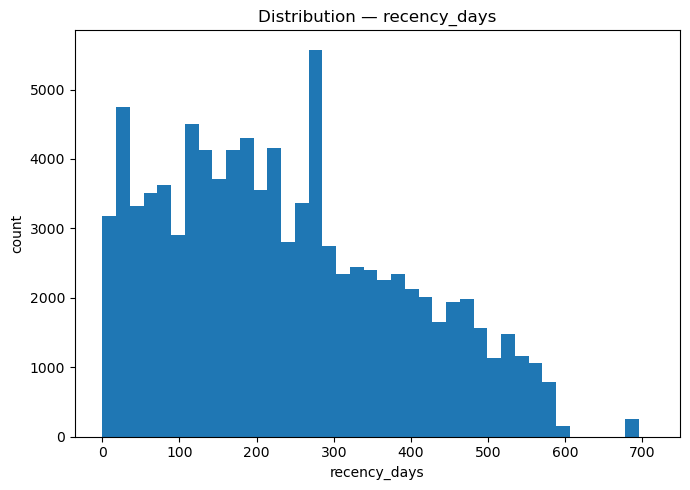

→ saved: outputs/img/rfm_dist_recency_days.png


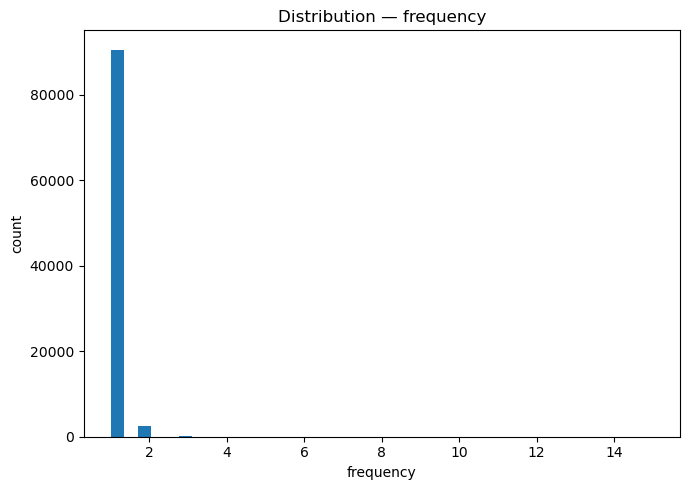

→ saved: outputs/img/rfm_dist_frequency.png


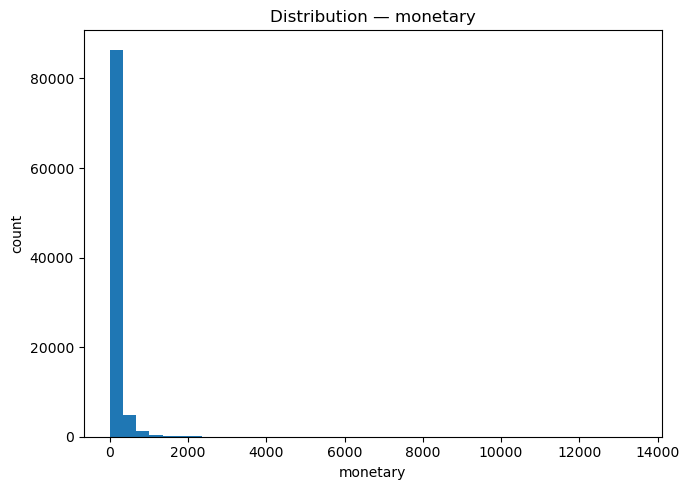

→ saved: outputs/img/rfm_dist_monetary.png


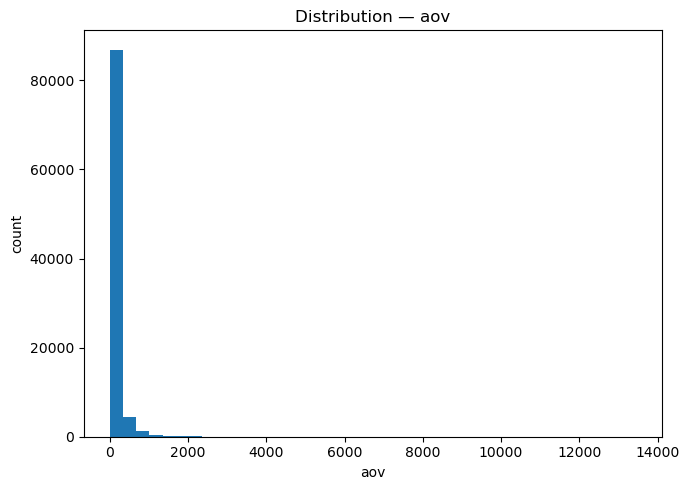

→ saved: outputs/img/rfm_dist_aov.png


In [4]:
for col in ["recency_days","frequency","monetary","aov"]:
    plt.figure(); plt.hist(rfm[col], bins=40); 
    plt.title(f"Distribution — {col}"); plt.xlabel(col); plt.ylabel("count")
    savefig(f"{OUT_IMG}/rfm_dist_{col}.png")

rfm.describe().round(2).to_csv(f"{OUT_TAB}/rfm_describe.csv")

1) recency_days

observation : distribution assez étalée (de 0 à ~700 jours) avec un gros ventre entre ~100 et ~400 jours.

Lecture : beaucoup de clients n’ont pas acheté récemment (plusieurs mois). Les tous derniers acheteurs (recency proche de 0) sont minoritaires.

Insight marketing : gros potentiel réactivation (email/promo “revenez”, coupons ciblés) vs. nurturing spécifique pour les récents pour les transformer en repeaters.

2) frequency

observation : pic massif à 1 ; très peu de clients au-delà (2, 3, 4…).

Lecture : Olist (retail multi-catégorie) a une base très majoritairement de one-time buyers. Les clients qui reviennent existent mais restent rares.

Insight marketing : le repeat est la croissance cachée. Travailler l’upsell/cross-sell post-achat, abonnements (consommables), programmes de fidélité, ou relances au bon moment (produits complémentaires).

3) monetary

observation : forte asymétrie à droite (long tail) : la majorité dépense peu, une minorité dépense beaucoup (quelques très gros paniers).

Lecture : loi de Pareto classique : une petite part de clients fait une grosse part du CA.

Insight marketing : isoler les VIP/high-value pour un traitement premium (service, avantages, early access). Côté modèle, attention aux outliers → standardisation indispensable (voire log-transform ou winsorisation légère pour la robustesse).

4) aov (Average Order Value)

observation : même signature que monetary (skewed). Beaucoup de paniers modestes, quelques paniers très élevés.

Lecture : la valeur d’une commande varie énormément selon le type de produit.

Insight marketing : scénarios de panier moyen (bundles, recommandations produits plus chers/complémentaires, frais de port offerts au-dessus d’un seuil).

In [5]:
# === KPIs RFM pour les slides ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rfm = rfm.copy()  # si déjà en mémoire
n = len(rfm)

# 1) One-timers vs repeaters
vc = rfm['frequency'].value_counts().sort_index()
one_time = int(vc.get(1, 0))
two_plus = n - one_time
kpis = {
    "n_clients": n,
    "one_time": one_time,
    "one_time_pct": round(100*one_time/n, 2),
    "repeaters": two_plus,
    "repeaters_pct": round(100*two_plus/n, 2),
}

# 2) Concentration du CA (Pareto)
rfm_sorted = rfm.sort_values('monetary', ascending=False).reset_index(drop=True)
rfm_sorted['cum_revenue_share'] = 100 * rfm_sorted['monetary'].cumsum() / rfm_sorted['monetary'].sum()
rfm_sorted['cum_clients_share']  = 100 * (np.arange(1, n+1) / n)

# Part du CA faite par le top x% clients
def top_share(xpct):
    k = int(np.ceil(xpct/100 * n))
    return round(100 * rfm_sorted.loc[:k-1, 'monetary'].sum() / rfm_sorted['monetary'].sum(), 2)

kpis.update({
    "top_1pct_CA":  top_share(1),
    "top_5pct_CA":  top_share(5),
    "top_10pct_CA": top_share(10),
    "top_20pct_CA": top_share(20),
})

# 3) Médianes utiles
kpis.update({
    "recency_median": int(rfm['recency_days'].median()),
    "frequency_median": float(rfm['frequency'].median()),
    "monetary_median": float(rfm['monetary'].median()),
    "aov_median": float(rfm['aov'].median()),
})
pd.DataFrame([kpis])

,n_clients,one_time,one_time_pct,repeaters,repeaters_pct,top_1pct_CA,top_5pct_CA,top_10pct_CA,top_20pct_CA,recency_median,frequency_median,monetary_median,aov_median
0,93358,90557,97.0,2801,3.0,11.47,29.13,41.1,56.62,218,1.0,89.73,86.99


KPIs RFM (base livrée)

Clients analysés : 93 358

One-timers (1 commande) : 90 557 (97 %)

Repeaters (≥ 2 commandes) : 2 801 (3 %)

Récence médiane : 218 jours

Fréquence médiane : 1

Monetary médian : 89,73 R$

Panier moyen (AOV) médian : 86,99 R$

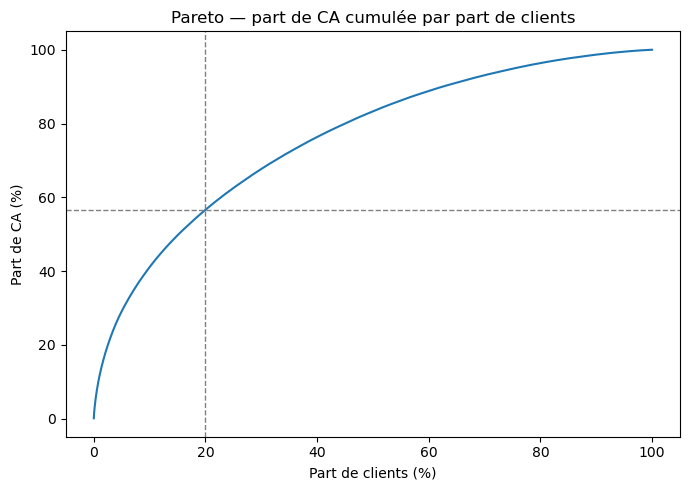

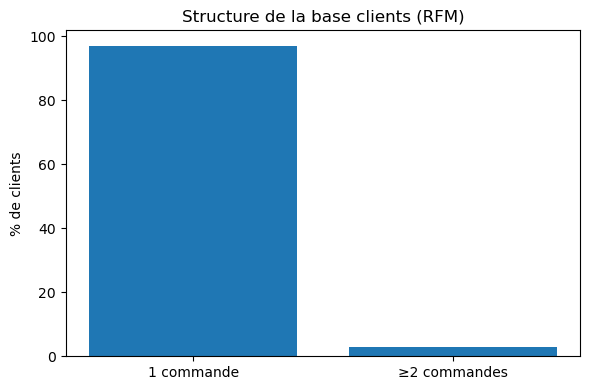

In [6]:
# Courbe de Pareto (part du CA vs part de clients)
plt.figure(figsize=(7,5))
plt.plot(rfm_sorted['cum_clients_share'], rfm_sorted['cum_revenue_share'])
plt.axvline(20, color='gray', linestyle='--', linewidth=1)
plt.axhline(top_share(20), color='gray', linestyle='--', linewidth=1)
plt.title("Pareto — part de CA cumulée par part de clients")
plt.xlabel("Part de clients (%)"); plt.ylabel("Part de CA (%)")
plt.tight_layout(); plt.savefig("outputs/img/rfm_pareto.png", dpi=140); plt.show()

# Bar chart one-timers vs repeaters
plt.figure(figsize=(6,4))
plt.bar(["1 commande","≥2 commandes"], [kpis["one_time_pct"], kpis["repeaters_pct"]])
plt.title("Structure de la base clients (RFM)")
plt.ylabel("% de clients")
plt.tight_layout(); plt.savefig("outputs/img/rfm_one_vs_repeat.png", dpi=140); plt.show()

Top 1 % des clients = 11,5 % du CA

Top 5 % = 29,1 % du CA

Top 10 % = 41,1 % du CA

Top 20 % = 56,6 % du CA

Lecture métier

La base est massivement one-shot (97 %). Le levier de croissance principal est donc la réachat (relances, cross/upsell, programmes de fidélité).

Le CA est très concentré : une petite élite (≤ 10–20 %) pèse une grosse part du revenu.
→ À isoler comme VIP pour un traitement premium (priorisation du service, incentives personnalisés).

Récence élevée (218 j) : beaucoup de clients “refroids” → campagnes de réactivation à prioriser.

Montants/paniers très asymétriques (cf. histos) : indispensables d’standardiser (ce qu’on fait) avant clustering.

---------- conclusion ------------

97 % des clients n’achètent qu’une fois ; 3 % seulement reviennent.

Le top 10 % de clients réalise 41 % du CA (forte concentration).

Récence médiane 218 j → fort potentiel réactivation.

----------------------------------

3) Standardisation & visual Exploration (PCA) – RFM

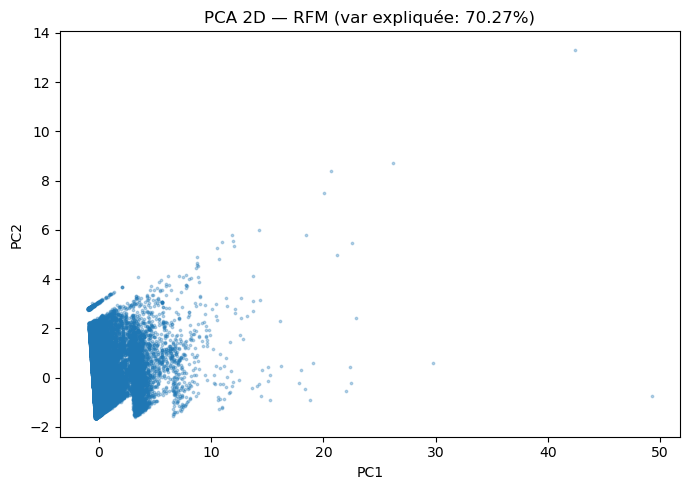

→ saved: outputs/img/rfm_pca2d.png


In [7]:
feat_rfm_cols = ["recency_days","frequency","monetary"]
X_rfm = rfm[feat_rfm_cols].copy()

scaler_rfm = StandardScaler()
Xs_rfm = scaler_rfm.fit_transform(X_rfm)

# PCA visuelle pour slide
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(Xs_rfm)
plt.figure()
plt.scatter(pc[:,0], pc[:,1], s=3, alpha=0.3)
plt.title(f"PCA 2D — RFM (var expliquée: {pca.explained_variance_ratio_.sum():.2%})")
plt.xlabel("PC1"); plt.ylabel("PC2")
savefig(f"{OUT_IMG}/rfm_pca2d.png")

Nuage dense près de l’origine → la très grande majorité des clients sont “ordinaires” : 1 commande, montant faible à moyen, et récence moyenne/élevée

Bandes verticales proches de x∈[0,5] → c’est un effet de quantification de la frequency (variable entière très dominante) : les clients avec 1, 2, 3… commandes se projettent en “stries” sur PC1.

Queue à droite (PC1 élevé, jusque ~50) → outliers à forte valeur (gros monetary et/ou frequency). Très peu nombreux, mais ils tirent fortement la variance → ce sont les VIP.

Quelques points plus hauts en PC2 que les autres → profils atypiques où la combinaison de récence vs fréquence/monétaire diffère du paquet central (ex. clients anciens mais à forte dépense, ou récents avec panier anormalement élevé).

,PC1,PC2
recency_days,-0.148,0.979
frequency,0.707,0.003
monetary,0.692,0.206


Variance expliquée par PC1+PC2 = 70.27%


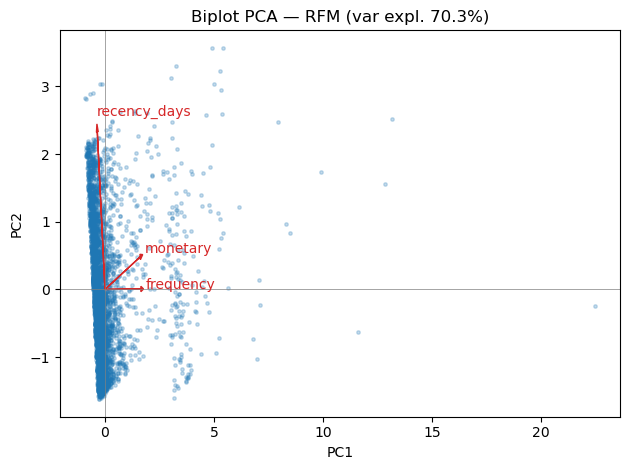

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Données & colonnes RFM
cols_rfm = ['recency_days','frequency','monetary']
assert set(cols_rfm).issubset(rfm.columns), "Colonnes RFM manquantes"
rfm_r = rfm.dropna(subset=cols_rfm).copy()

# --- Standardisation
scaler = StandardScaler()
Xs_rfm = scaler.fit_transform(rfm_r[cols_rfm])

# --- PCA 2D
pca = PCA(n_components=2, random_state=42).fit(Xs_rfm)
loadings = pd.DataFrame(pca.components_.T, index=cols_rfm, columns=['PC1','PC2'])
expl = pca.explained_variance_ratio_.sum()*100
display(loadings.round(3))
print(f"Variance expliquée par PC1+PC2 = {expl:.2f}%")

# --- Biplot
Z = pca.transform(Xs_rfm)
n_plot = min(4000, Z.shape[0])
idx = np.random.RandomState(42).choice(Z.shape[0], size=n_plot, replace=False)

plt.figure(figsize=(6.4,4.8))
plt.scatter(Z[idx,0], Z[idx,1], s=6, alpha=0.25)
plt.title(f"Biplot PCA — RFM (var expl. {expl:.1f}%)")
plt.xlabel("PC1"); plt.ylabel("PC2")

scale = 2.5
for v in cols_rfm:
    x, y = loadings.loc[v,'PC1']*scale, loadings.loc[v,'PC2']*scale
    plt.arrow(0, 0, x, y, head_width=0.08, head_length=0.12,
              length_includes_head=True, color='tab:red')
    plt.text(x*1.05, y*1.05, v, color='tab:red')

plt.axhline(0, color='gray', lw=0.5); plt.axvline(0, color='gray', lw=0.5)
plt.tight_layout(); plt.show()

PC1 ≈ 0.71·frequency + 0.69·monetary − 0.15·recency
→ c’est un axe “valeur/activité” : plus on va à droite, plus le client a acheté souvent et dépensé beaucoup (et un peu plus récent).

PC2 ≈ 0.98·recency + 0.21·monetary (frequency ~ 0)
→ c’est un axe “récence” quasi pur : plus on monte, plus le dernier achat est vieux (grands recency_days). Plus on descend, plus le client est récent.

Biplot (flèches rouges)

Les flèches indiquent dans quel sens chaque variable tire les points.

frequency et monetary pointent surtout vers PC1 → ils structurent l’horizontal (valeur/activité).

recency_days pointe vers PC2 → elle structure le vertical (ancien ⇡ / récent ⇣).

Nuage de points

Gros nuage serré près de l’origine : la masse de clients “standard” (1 commande, faible spend, récence moyenne/élevée) — cohérent avec 97 % de one-timers.

Longue traîne à droite (PC1 élevé) : les clients à forte valeur (VIP, repeaters) peu nombreux mais qui expliquent beaucoup de variance.

Dispersion verticale = différences de récence (en haut plus anciens, en bas plus récents).

Lecture métier par quadrants

Droite–bas (PC1↑, PC2↓) : haute valeur & récents → clients “champions” à choyer, eligible pour upsell/cross-sell premium.

Droite–haut (PC1↑, PC2↑) : haute valeur mais anciens → VIP en dormance → réactivation personnalisée (offre VIP, win-back).

Gauche–bas (PC1↓, PC2↓) : faible valeur mais récents → nouveaux à nurturer pour les faire revenir (welcome flows, bundles).

Gauche–haut (PC1↓, PC2↑) : faible valeur & anciens → one-shot froids → campagnes low-cost (emails, promos ciblées), sinon à laisser filer.

4) KMeans RFM : coude & silhouette (K=3..7)

K = 1 n’a aucun sens pour un clustering : tout le monde est dans le même segment, l’inertie est triviale et la silhouette n’est pas définie (il faut au moins 2 clusters).

K = 2 est calculable, mais très souvent trop grossier pour le marketing (deux seaux « bons / moins bons »). On vise des segments actionnables (3-7 segments) sans sur-segmenter.

Le choix 3 → 7 vient donc de deux contraintes :

métier : nombre de segments gérable pour des campagnes,

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


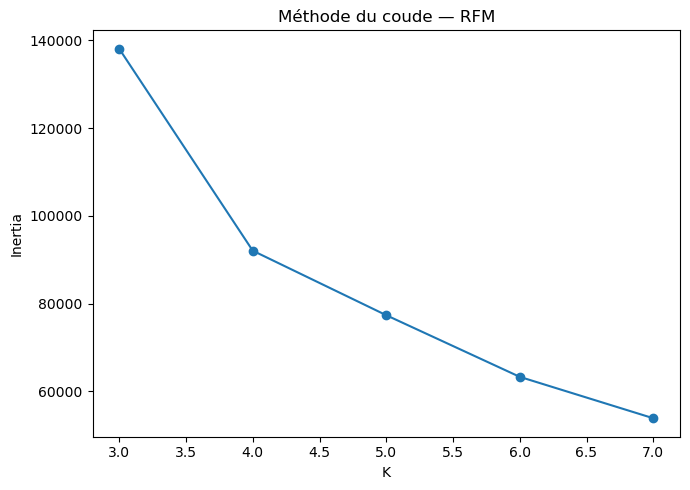

→ saved: outputs/img/rfm_elbow.png


In [9]:
Ks = [3,4,5,6,7]
inertias, sils = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=42)
    lab = km.fit_predict(Xs_rfm)
    inertias.append(km.inertia_)
    # silhouette sur échantillon 8000 pour vitesse
    idx = np.random.RandomState(42).choice(Xs_rfm.shape[0], size=min(8000, Xs_rfm.shape[0]), replace=False)
    sils.append(silhouette_score(Xs_rfm[idx], lab[idx]))

plt.figure(); plt.plot(Ks, inertias, marker='o')
plt.title("Méthode du coude — RFM"); plt.xlabel("K"); plt.ylabel("Inertia")
savefig(f"{OUT_IMG}/rfm_elbow.png")

Méthode du coude (Inertia vs K)

Inertia = somme des distances au centroïde dans chaque cluster (plus c’est bas, plus les points sont compacts).

En augmentant K, l’inertia baisse toujours (on “coupe” plus fin). Le but est de repérer le coude : la zone où le gain marginal devient faible.

Ici, la baisse est très forte de K=3 → K=4, puis plus douce après.
    
Coude visuel autour de K=4.

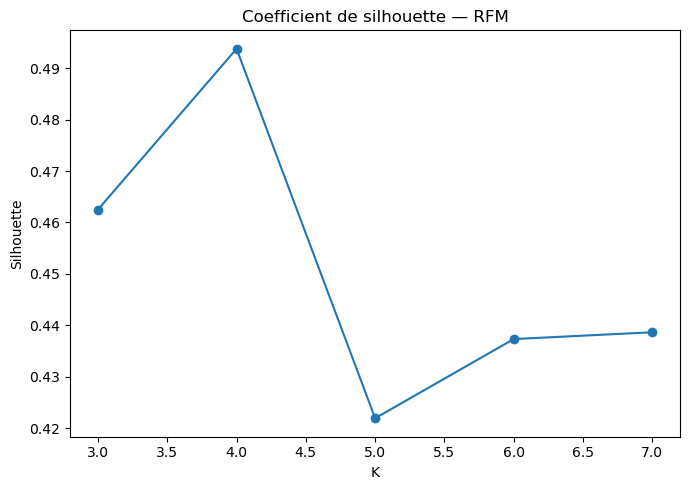

→ saved: outputs/img/rfm_silhouette.png
K choisi (silhouette max, RFM) → 4


In [10]:
plt.figure(); plt.plot(Ks, sils, marker='o')
plt.title("Coefficient de silhouette — RFM"); plt.xlabel("K"); plt.ylabel("Silhouette")
savefig(f"{OUT_IMG}/rfm_silhouette.png")

k_best_rfm = Ks[int(np.argmax(sils))]
print("K choisi (silhouette max, RFM) →", k_best_rfm)

Coefficient de silhouette (moyen)

Mesure [−1, 1] qui combine compacité (points proches de leur centroïde) et séparation (loin des autres clusters).

Plus c’est haut, mieux c’est (≈ >0.25 acceptable, >0.40 bon, >0.50 très bon selon les contextes).

Chez toi : pic à K=4 (~0.493), puis chute à K=5 et légère remontée à 6–7.
    
K=4 donne la meilleure séparation/compacité.

---------conclusion--------

Les deux critères convergent : K optimal ≈ 4 sur RFM.

K=5…7 segmente trop finement sans gain de qualité (silhouette plus faible), K=3 est trop grossier (inertia encore élevée).

---------------------------

5) Fit final KMeans sur RFM + profiling métier (radar/PCA colorée)

In [11]:
km_rfm = KMeans(n_clusters=k_best_rfm, n_init=20, algorithm="elkan", random_state=42)
rfm["cluster_rfm"] = km_rfm.fit_predict(Xs_rfm)

# Profiling médian
prof_rfm = (rfm.groupby("cluster_rfm")
            .agg(n_clients=("customer_id","count"),
                 recency_med=("recency_days","median"),
                 freq_med=("frequency","median"),
                 monetary_med=("monetary","median"),
                 monetary_sum=("monetary","sum"))
            .reset_index().sort_values("cluster_rfm"))
display(prof_rfm)
prof_rfm.to_csv(f"{OUT_TAB}/rfm_profiling.csv", index=False)

,cluster_rfm,n_clients,recency_med,freq_med,monetary_med,monetary_sum
0,0,37564,374.0,1.0,82.90,4285065.93
1,1,2774,199.0,2.0,179.98,674529.29
2,2,2188,221.0,1.0,914.65,2499220.24
3,3,50832,129.0,1.0,84.90,5762682.65


Cluster 0 — n=37 564 • CA≈4.29 M R$ (~32%)
→ one-shot anciens : achat unique, vieux, panier faible.

Cluster 1 — n=2 774 • CA≈0.67 M R$ (~5%)
→ petits repeaters : 2 achats en médiane, panier moyen correct, pas très récents.

Cluster 2 — n=2 188 • CA≈2.50 M R$ (~19%)
→ gros paniers / high-spenders (souvent 1 achat mais très élevé), plutôt anciens.

Cluster 3 — n=50 832 • CA≈5.76 M R$ (~44%)
→ one-shot récents : masse volumique, panier faible, récents → fort potentiel de nurturing.

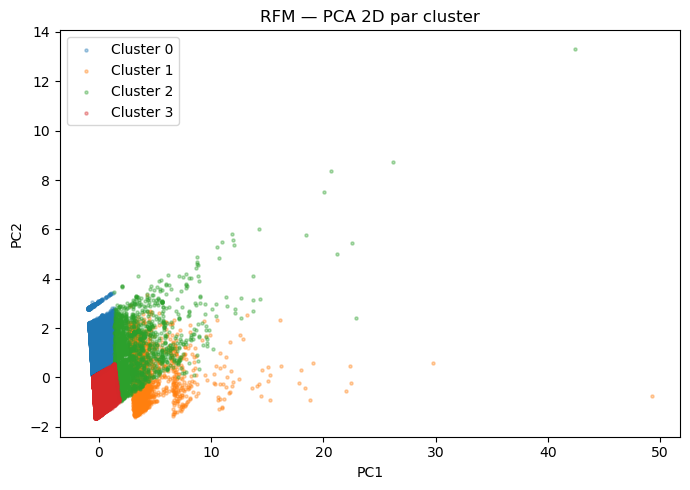

→ saved: outputs/img/rfm_pca2d_clusters.png


In [12]:
# PCA 2D colorée
pc = PCA(n_components=2, random_state=42).fit_transform(Xs_rfm)
plt.figure()
for c in sorted(rfm["cluster_rfm"].unique()):
    mask = (rfm["cluster_rfm"]==c)
    plt.scatter(pc[mask,0], pc[mask,1], s=5, alpha=0.35, label=f"Cluster {c}")
plt.title("RFM — PCA 2D par cluster"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
savefig(f"{OUT_IMG}/rfm_pca2d_clusters.png")

PC1 (axe horizontal) = intensité de valeur d’achat

frequency (nb de commandes) et monetary (dépense totale).

→ À droite : clients qui achètent plus et/ou dépensent plus.
→ À gauche : clients peu actifs et peu dépensiers.

PC2 (axe vertical) = récence

Quasi recency_days.

→ En haut : récents (peu de jours depuis la dernière commande).
→ En bas : dormants/anciens (beaucoup de jours depuis la dernière commande).

PCA 2D colorée

Axe horizontal (PC1) = valeur/activité (frequency & monetary ↑ → droite).
    
Axe vertical (PC2) = récence (haut = plus ancien).

Cluster 2 part vers la droite (paniers élevés).

Cluster 3 reste bas (récents).

Cluster 0 monte en haut-gauche (anciens & faible valeur).

Cluster 1 s’étale un peu à droite (2 achats) mais reste modéré en récence.

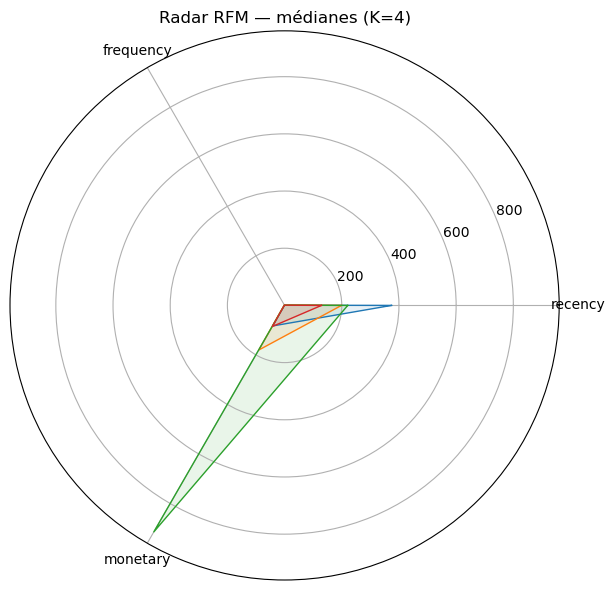

→ saved: outputs/img/rfm_radar.png


In [13]:
# Radar (médianes normalisées)
def radar_plot(df, cols, label_col, title, out_png):
    # normalisation [0,1] par colonne
    M = df[cols].astype(float)
    M = (M - M.min())/(M.max()-M.min()+1e-9)
    labels = cols; N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist() + [0]
    plt.figure(figsize=(7,6))
    ax = plt.subplot(111, polar=True)
    for _, row in df.iterrows():
        vals = row[cols].tolist(); vals.append(vals[0])
        ax.plot(angles, vals, linewidth=1)
        ax.fill(angles, vals, alpha=0.1)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_title(title)
    savefig(out_png)

radar_plot(
    prof_rfm.rename(columns={"recency_med":"recency","freq_med":"frequency","monetary_med":"monetary"}),
    ["recency","frequency","monetary"],
    "cluster_rfm",
    f"Radar RFM — médianes (K={k_best_rfm})",
    f"{OUT_IMG}/rfm_radar.png"
)

Radar (médianes)

recency très faible (donc mieux) pour le cluster 3 ; monetary écrasant pour le cluster 2 ; seule la frequency=2 se voit dans le cluster 1.

--------------------Interprétation marketing----------------------

Cluster 3 — “Nouveaux/Actifs à convertir” (54% des clients, 44% du CA)
Qui ? One-shot récents, panier bas.
Pourquoi c’est clé ? Gros volume : chaque point de reconversion compte.
Actions : séries d’emails post-achat, bundles d’entrée, coupons 2ᵉ commande, recommandations produit, relances J+7/J+30.

Cluster 0 — “One-shot anciens / froids” (40% des clients, 32% du CA)
Qui ? Anciens, panier bas.
Actions : campagnes win-back low-cost (email/SMS), offres flash, ciblage sur catégories vues ; si pas d’ouverture → baisser la pression (hygiène base).

Cluster 1 — “Repeaters légers” (3% des clients, 5% du CA)
Qui ? 2 achats, panier correct.
Actions : programme fidélité simple, abonnements/auto-replenish, reco produits complémentaires, early access ventes privées.

Cluster 2 — “High-Spenders / VIP dormants” (2% des clients, 19% du CA)
Qui ? Panier très élevé, récence moyenne/haute (risque de churn).
Actions : traitement VIP (support prioritaire, cadeaux), relance personnalisée haut de gamme, offres limitées, rappel panier abandonné premium.

----------------------------------------------------------------------

cluster 3 : à convertir

cluster 2 : ne pas perdre

6) RFM + 3 features service (avg review, retard ≥3j, AOV)

In [14]:
rfm_ext_sql = f"""
/* RFM + features service par customer_unique_id (commandes livrées) */
WITH delivered AS (
  SELECT 
      o.order_id,
      c.customer_unique_id                      AS customer_id,
      DATE(o.order_purchase_timestamp)          AS order_date,
      DATE(o.order_delivered_customer_date)     AS delivered_date,
      DATE(o.order_estimated_delivery_date)     AS eta_date
  FROM {orders_t} o
  JOIN {customers_t} c ON c.customer_id = o.customer_id
  WHERE o.order_status = 'delivered'
),
orders_revenue AS (
  SELECT 
      d.customer_id,
      d.order_id,
      d.order_date,
      d.delivered_date,
      d.eta_date,
      SUM(oi.price) AS order_revenue
  FROM delivered d
  JOIN {items_t} oi ON oi.order_id = d.order_id
  GROUP BY d.customer_id, d.order_id, d.order_date, d.delivered_date, d.eta_date
),
bounds AS (
  SELECT DATE(MAX(order_date)) AS max_date FROM orders_revenue
),
rfm AS (
  SELECT
      r.customer_id,
      CAST(julianday((SELECT max_date FROM bounds)) - julianday(MAX(r.order_date)) AS INT) AS recency_days,
      COUNT(DISTINCT r.order_id)                                  AS frequency,
      ROUND(SUM(r.order_revenue), 2)                              AS monetary,
      ROUND(AVG(r.order_revenue), 2)                              AS aov
  FROM orders_revenue r
  GROUP BY r.customer_id
),
reviews_by_order AS (
  SELECT orv.order_id, AVG(orv.review_score) AS review_score_order
  FROM {reviews_t} orv
  GROUP BY orv.order_id
),
reviews_by_customer AS (
  SELECT r.customer_id, AVG(rv.review_score_order) AS avg_review_score
  FROM orders_revenue r
  LEFT JOIN reviews_by_order rv ON rv.order_id = r.order_id
  GROUP BY r.customer_id
),
delays_by_customer AS (
  SELECT
      r.customer_id,
      AVG(
        CASE
          WHEN r.delivered_date IS NOT NULL AND r.eta_date IS NOT NULL
               AND CAST(julianday(r.delivered_date) - julianday(r.eta_date) AS INT) >= 3
          THEN 1.0 ELSE 0.0
        END
      ) AS delay_rate_ge3d
  FROM orders_revenue r
  GROUP BY r.customer_id
)
SELECT
    f.customer_id,
    f.recency_days, f.frequency, f.monetary, f.aov,
    rc.avg_review_score,
    d.delay_rate_ge3d
FROM rfm f
LEFT JOIN reviews_by_customer rc ON rc.customer_id = f.customer_id
LEFT JOIN delays_by_customer  d  ON d.customer_id  = f.customer_id;
"""
feat = pd.read_sql_query(rfm_ext_sql, conn)
# gérer les NaN (clients sans review/retard)
for c in ["avg_review_score","delay_rate_ge3d"]:
    feat[c] = feat[c].fillna(feat[c].median())
feat.to_parquet(f"{OUT_TAB}/rfm_plus_features.parquet", index=False)
display(feat.head())

,customer_id,recency_days,frequency,monetary,aov,avg_review_score,delay_rate_ge3d
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,129.90,5.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,18.90,4.0,0.0
2,0000f46a3911fa3c0805444483337064,537,1,69.00,69.00,3.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,25.99,4.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,180.00,5.0,0.0


customer_id : l’identifiant client.

recency_days : nb de jours depuis la dernière commande (plus petit = plus récent).

frequency : nb de commandes livrées (1 pour la plupart des clients Olist).

monetary : CA total dépensé par le client (somme des prix des commandes livrées).

aov : panier moyen (= monetary / frequency).
➜ Tant que frequency=1, aov = monetary. L’info devient utile surtout pour les repeaters.

avg_review_score : moyenne des notes de review du client sur ses commandes (échelle 1–5).

delay_rate_ge3d : taux de commandes du client livrées avec ≥3 jours de retard (entre 0 et 1).

7) Standardisation et comparaison de variantes (RFM vs RFM+review vs RFM+review+delay+AOV)

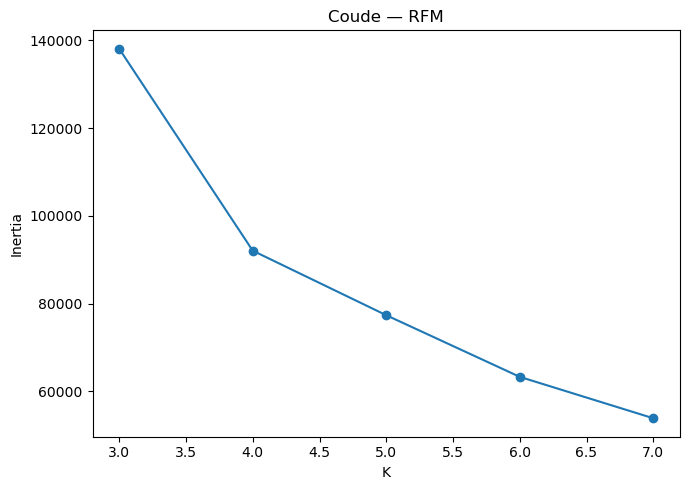

→ saved: outputs/img/elbow_RFM.png


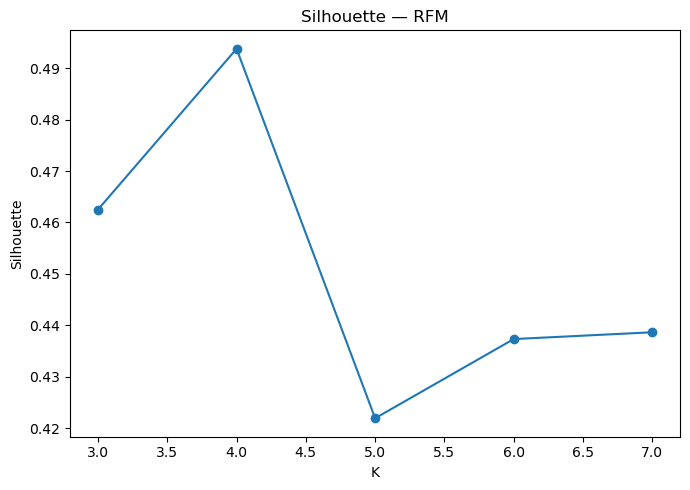

→ saved: outputs/img/silhouette_RFM.png


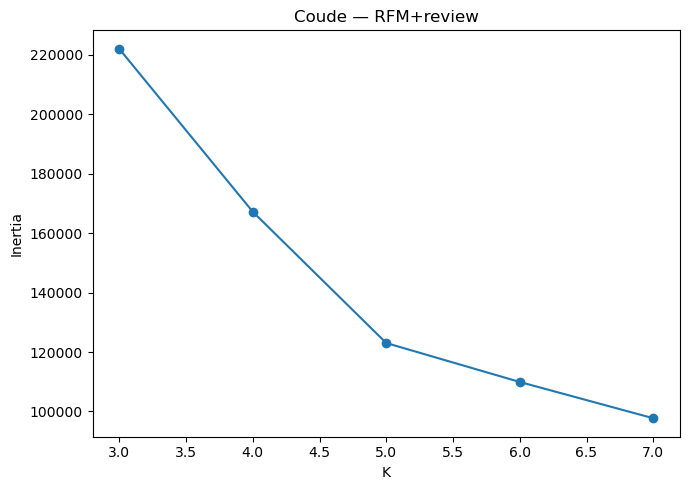

→ saved: outputs/img/elbow_RFM+review.png


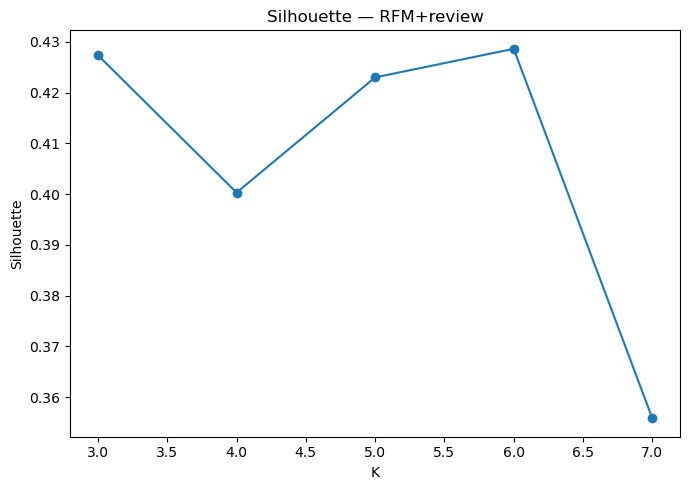

→ saved: outputs/img/silhouette_RFM+review.png


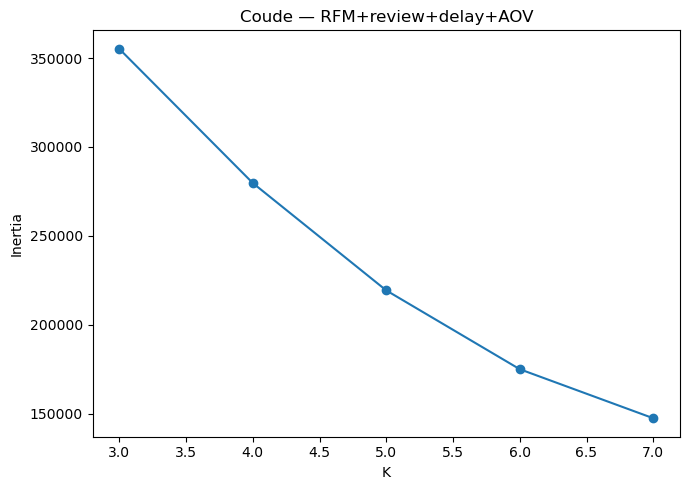

→ saved: outputs/img/elbow_RFM+review+delay+AOV.png


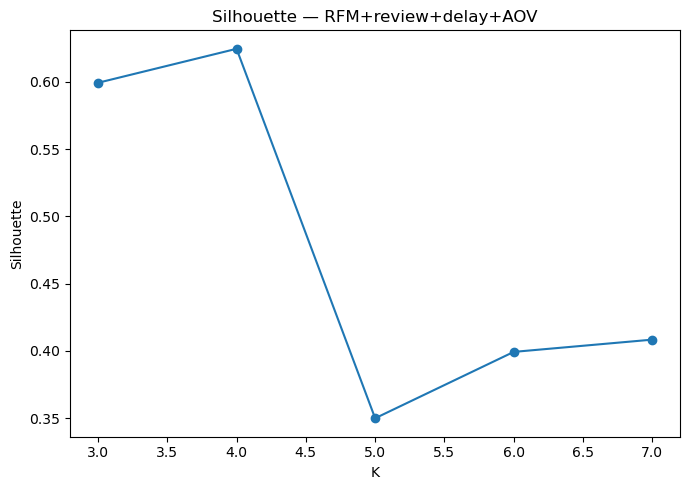

→ saved: outputs/img/silhouette_RFM+review+delay+AOV.png


,k,3,4,5,6,7
variant,n_features,,,,,
RFM,3,0.463,0.494,0.422,0.437,0.439
RFM+review,4,0.427,0.400,0.423,0.429,0.356
RFM+review+delay+AOV,6,0.599,0.625,0.350,0.399,0.408


In [15]:
variants = {
    "RFM": ["recency_days","frequency","monetary"],
    "RFM+review": ["recency_days","frequency","monetary","avg_review_score"],
    "RFM+review+delay+AOV": ["recency_days","frequency","monetary","avg_review_score","delay_rate_ge3d","aov"],
}

def std_mat(df, cols):
    sc = StandardScaler()
    return sc.fit_transform(df[cols].astype(float)), sc

comp_rows = []
Ks = [3,4,5,6,7]
for vname, cols in variants.items():
    Xs, _ = std_mat(feat, cols)
    inertias, sils = [], []
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=42)
        lab = km.fit_predict(Xs)
        inertias.append(km.inertia_)
        idx = np.random.RandomState(42).choice(Xs.shape[0], size=min(8000, Xs.shape[0]), replace=False)
        sils.append(silhouette_score(Xs[idx], lab[idx]))
    # plots
    plt.figure(); plt.plot(Ks, inertias, marker='o'); 
    plt.title(f"Coude — {vname}"); plt.xlabel("K"); plt.ylabel("Inertia")
    savefig(f"{OUT_IMG}/elbow_{vname}.png")
    plt.figure(); plt.plot(Ks, sils, marker='o'); 
    plt.title(f"Silhouette — {vname}"); plt.xlabel("K"); plt.ylabel("Silhouette")
    savefig(f"{OUT_IMG}/silhouette_{vname}.png")
    for k, si in zip(Ks, sils):
        comp_rows.append({"variant": vname, "k": k, "silhouette": si, "n_features": len(cols)})
comp = pd.DataFrame(comp_rows)
pivot = comp.pivot_table(index=["variant","n_features"], columns="k", values="silhouette")
display(pivot.round(3))
pivot.round(3).to_csv(f"{OUT_TAB}/silhouette_variants.csv")

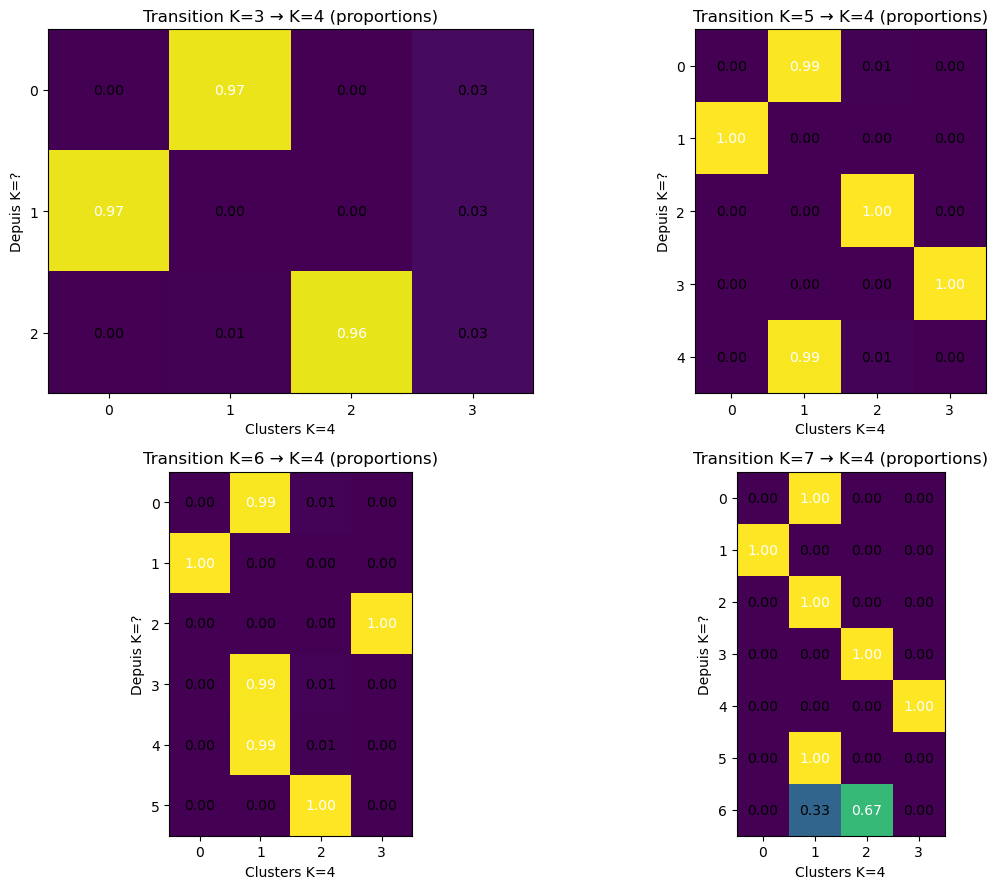

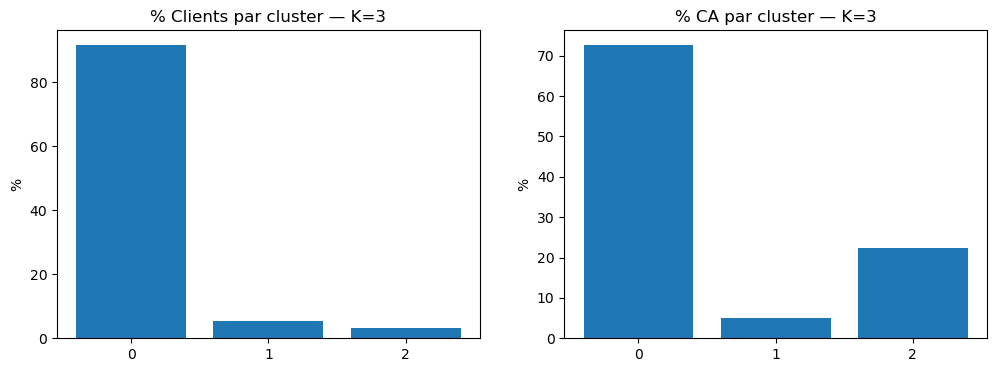

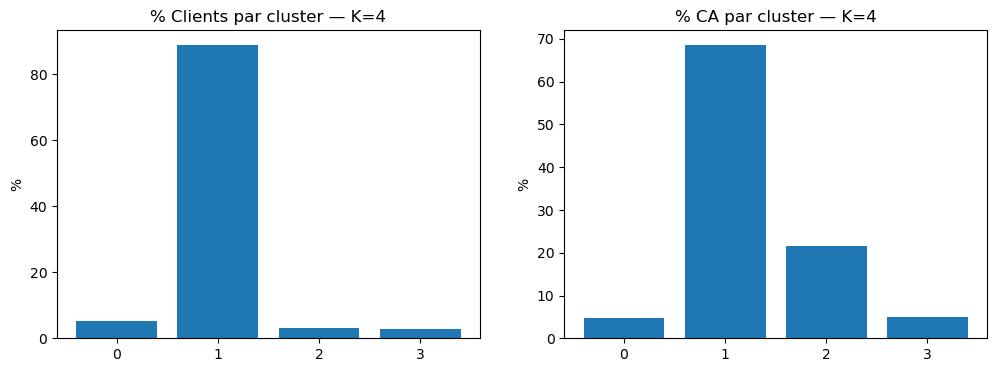

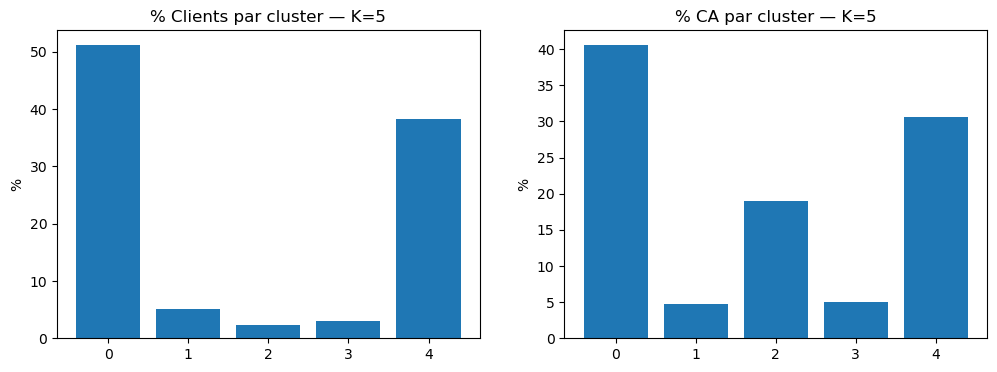

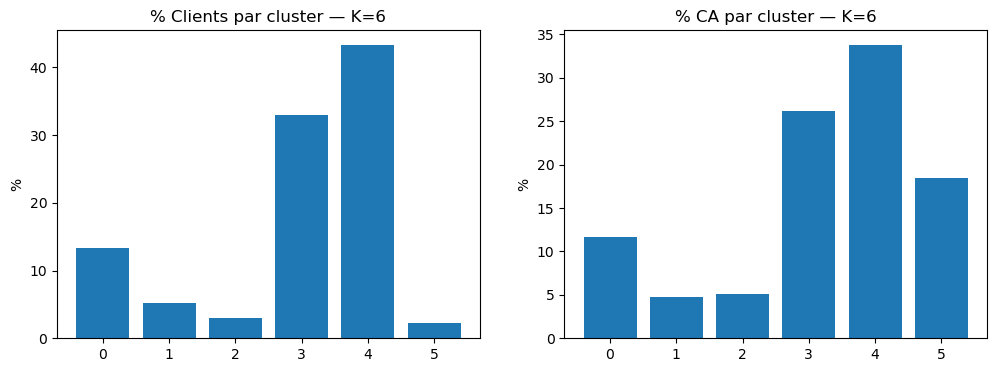

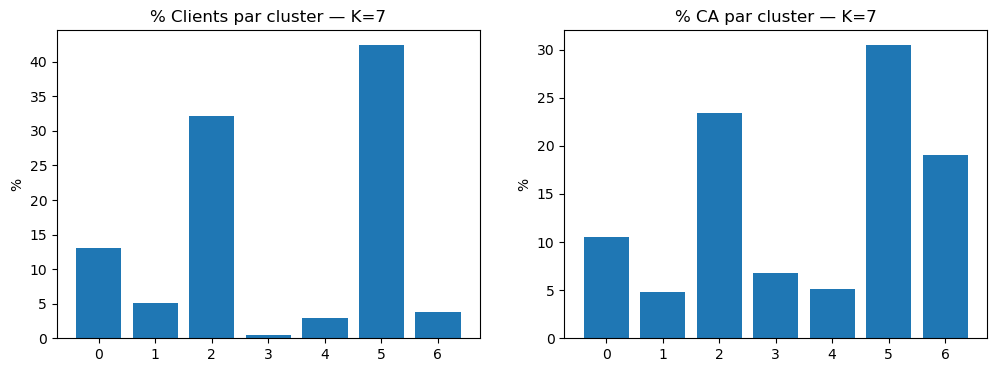

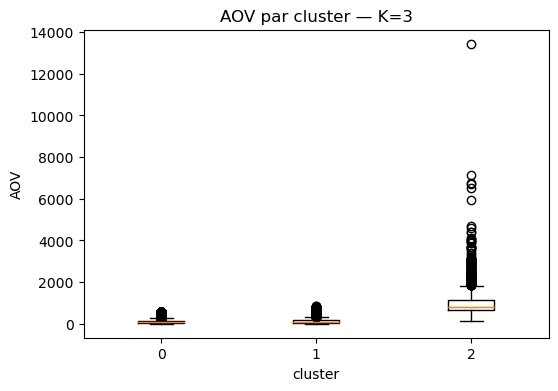

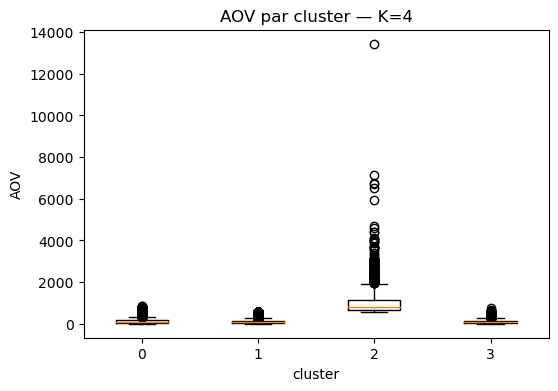

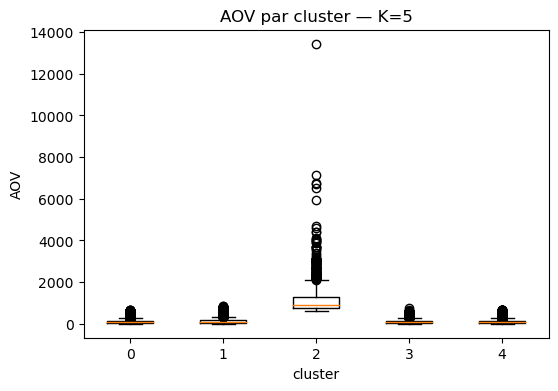

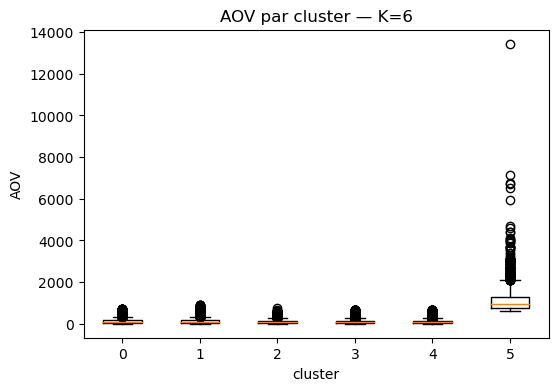

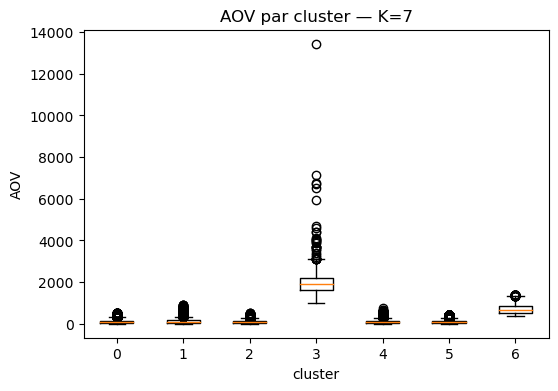

,cluster,n_clients,recency_med,freq_med,monetary_med,aov_med,monetary_sum,review_med,delay_med,clients_share_%,revenue_share_%,k
0,0,85510,220.0,1.0,84.990,81.000,9602572.05,5.0,0.0,91.593650,72.628472,3
1,2,2893,230.0,1.0,829.990,799.900,2955252.81,5.0,0.0,3.098824,22.351876,3
2,1,4955,190.0,1.0,95.900,90.000,663673.25,1.0,1.0,5.307526,5.019652,3
3,1,83006,221.0,1.0,80.275,80.275,9068622.01,5.0,0.0,88.911502,68.589973,4
4,2,2783,231.0,1.0,820.000,816.000,2853664.29,5.0,0.0,2.980998,21.583517,4


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ========= 1) Helpers =========

def fit_k(labels_store, k, Xs, random_state=42):
    """Fit KMeans(K) sur Xs et mémorise les labels dans labels_store[k]."""
    km = KMeans(n_clusters=k, n_init=50, algorithm="elkan", random_state=random_state)
    labels = km.fit_predict(Xs)
    labels_store[k] = labels
    return labels

def profile_clusters(feat, labels, k):
    """Profil métier par cluster: effectifs, médianes, part CA."""
    df = feat.copy()
    df["cluster"] = labels.astype(int)
    has_review = "avg_review_score" in df.columns
    has_delay  = "delay_rate_ge3d" in df.columns
    
    agg = {
        "customer_id": ("customer_id","count"),
        "recency_days": ("recency_days","median"),
        "frequency":   ("frequency","median"),
        "monetary":    ("monetary","median"),
        "aov":         ("aov","median"),
        "monetary_sum": ("monetary","sum")
    }
    if has_review:
        agg["review_med"] = ("avg_review_score","median")
    if has_delay:
        agg["delay_med"]  = ("delay_rate_ge3d","median")
    
    # construire groupby proprement
    gb = (df.groupby("cluster")
            .agg(**agg)
            .rename(columns={
                "customer_id":"n_clients",
                "recency_days":"recency_med",
                "frequency":"freq_med",
                "monetary":"monetary_med",
                "aov":"aov_med"
            })
            .reset_index())
    total_clients = gb["n_clients"].sum()
    total_ca      = gb["monetary_sum"].sum()
    gb["clients_share_%"]  = 100 * gb["n_clients"] / (total_clients if total_clients else 1)
    gb["revenue_share_%"]  = 100 * gb["monetary_sum"] / (total_ca if total_ca else 1)
    gb["k"] = k
    # tri par part de CA décroissante pour la lecture
    gb = gb.sort_values("revenue_share_%", ascending=False).reset_index(drop=True)
    return gb

def heatmap(ax, M, title, cmap="viridis"):
    """Heatmap avec annotations (matrice numpy 2D)."""
    im = ax.imshow(M, cmap=cmap, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_xlabel("Clusters K=4")
    ax.set_ylabel("Depuis K=?")
    ax.set_xticks(range(M.shape[1])); ax.set_yticks(range(M.shape[0]))
    # annotations
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, f"{M[i,j]:.2f}", ha="center", va="center", color="white" if M[i,j]>0.5 else "black")
    return im

# ========= 2) Fit labels pour K = 3..7 =========

labels_by_k = {}
for k in [3,4,5,6,7]:
    fit_k(labels_by_k, k, Xs)

# ========= 3) Matrices de transition vs K=4 =========
# (on normalise par ligne pour voir la proportion d'anciens clusters qui deviennent chaque cluster K=4)

crosstabs = {}
for k in [3,5,6,7]:
    ct = pd.crosstab(labels_by_k[k], labels_by_k[4], normalize='index')  # lignes = K=?, colonnes = K=4
    crosstabs[k] = ct

# Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
ax_list = axes.ravel()
for idx, k in enumerate([3,5,6,7]):
    M = crosstabs[k].reindex(index=sorted(crosstabs[k].index), columns=sorted(crosstabs[k].columns)).fillna(0).values
    heatmap(ax_list[idx], M, title=f"Transition K={k} → K=4 (proportions)")
fig.tight_layout()
plt.show()

# ========= 4) Profils métiers & Graphes =========

profiles = {}
for k in [3,4,5,6,7]:
    profiles[k] = profile_clusters(feat, labels_by_k[k], k)

# a) Barplots % Clients & % CA pour chaque K
for k in [3,4,5,6,7]:
    prof = profiles[k].sort_values("cluster")  # pour un ordre stable des barres
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].bar(prof["cluster"].astype(str), prof["clients_share_%"])
    ax[0].set_title(f"% Clients par cluster — K={k}")
    ax[0].set_ylabel("%")
    ax[1].bar(prof["cluster"].astype(str), prof["revenue_share_%"])
    ax[1].set_title(f"% CA par cluster — K={k}")
    ax[1].set_ylabel("%")
    plt.show()

# b) Boxplots AOV par cluster pour chaque K (utile pour visualiser la dispersion et les outliers)
for k in [3,4,5,6,7]:
    df = feat.copy()
    df["cluster"] = labels_by_k[k]
    fig, ax = plt.subplots(figsize=(6,4))
    # mettre les clusters dans l'ordre croissant
    order = sorted(df["cluster"].unique())
    data = [df.loc[df["cluster"]==c, "aov"].values for c in order]
    ax.boxplot(data, labels=[str(c) for c in order], showfliers=True)
    ax.set_title(f"AOV par cluster — K={k}")
    ax.set_xlabel("cluster")
    ax.set_ylabel("AOV")
    plt.show()

# c) (optionnel) Export CSV récap profils
out = pd.concat(profiles.values(), ignore_index=True)
out.to_csv("outputs/model/profiles_by_k.csv", index=False)
display(out.head())

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# 1) matrice de features
cols = ['recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']  # adapte si besoin
X = feat[cols].values
Xs = StandardScaler().fit_transform(X)

# 2) KMeans pour K = 3, 4, 5
def kmeans_labels(Xs, k, seed=42):
    return KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=seed).fit_predict(Xs)

labels_k3 = kmeans_labels(Xs, 3)
labels_k4 = kmeans_labels(Xs, 4)
labels_k5 = kmeans_labels(Xs, 5)

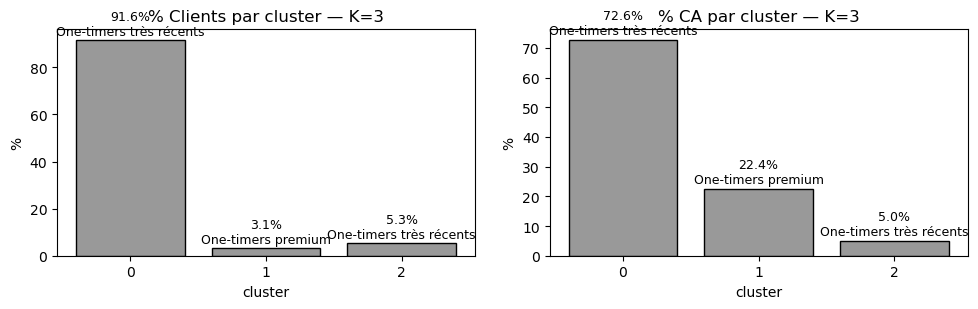

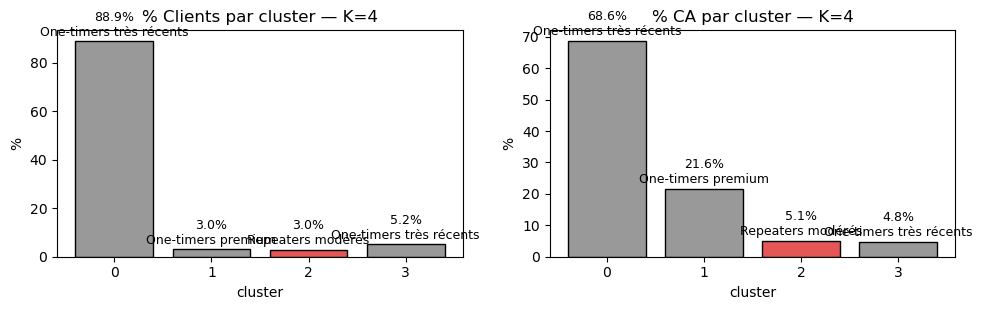

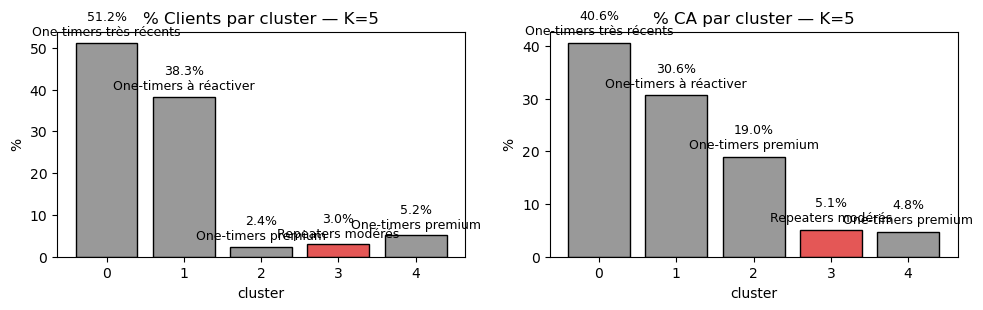

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- 1) Profil par cluster (identique à ce qu’on a déjà)
def quick_profile(feat_df, labels):
    prof = (feat_df.assign(cluster=labels)
            .groupby('cluster', as_index=False)
            .agg(n_clients=('customer_id','count'),
                 recency_med=('recency_days','median'),
                 freq_med=('frequency','median'),
                 monetary_med=('monetary','median'),
                 aov_med=('aov','median'),
                 review_med=('avg_review_score','median'),
                 delay_med=('delay_rate_ge3d','median'),
                 monetary_sum=('monetary','sum')))
    tot_c = prof['n_clients'].sum(); tot_r = prof['monetary_sum'].sum()
    prof['clients_share_%'] = 100*prof['n_clients']/tot_c
    prof['revenue_share_%'] = 100*prof['monetary_sum']/tot_r
    return prof.sort_values('revenue_share_%', ascending=False).reset_index(drop=True)

# --- 2) Attribution automatique d’un persona (règles simples & robustes)
def infer_personas(prof):
    prof = prof.copy()

    # Seuils data-driven (quantiles) pour discrétiser récence et AOV
    r_q70 = prof['recency_med'].quantile(0.70)   # au-delà = plus anciens
    aov_q75 = prof['aov_med'].quantile(0.75)     # au-delà = panier élevé

    personas = []
    for _, row in prof.iterrows():
        rec = float(row['recency_med'])
        freq = float(row['freq_med'])
        aov = float(row['aov_med'])
        mon = float(row.get('monetary_med', aov))

        # 1) One-timers mais on les scinde :
        if freq <= 1.0:
            if aov >= aov_q75:
                personas.append("One-timers premium")
            elif rec > r_q70:
                personas.append("One-timers à réactiver")
            else:
                personas.append("One-timers très récents")
            continue

        # 2) Repeaters (≥2)
        if freq >= 2.0 and rec <= r_q70:
            personas.append("Repeaters modérés")
            continue

        # 3) Whales (valeur/panier élevés)
        if aov >= aov_q75 or mon >= prof['monetary_med'].quantile(0.75):
            personas.append("Whales (AOV/€)")
            continue

        # 4) Par défaut
        personas.append("Standard")

    prof['persona'] = personas
    return prof

# --- 3) Bar charts annotés avec personas (même couleurs pour mêmes personas)
PALETTE = {
    "One-timers récents":   "#4C78A8",
    "Dormants":             "#F58518",
    "Whales (AOV/€)":       "#54A24B",
    "Repeaters modérés":    "#E45756",
    "Standard":             "#72B7B2"
}

def plot_share_bars_with_persona(prof, title_prefix=""):
    prof = prof.copy()
    # Garder un ordre lisible : décroissant en % CA
    prof = prof.sort_values('revenue_share_%', ascending=False).reset_index(drop=True)
    colors = [PALETTE.get(p, "#999999") for p in prof['persona']]

    fig, axes = plt.subplots(1,2, figsize=(10,3.2), sharey=False)
    # % clients
    axes[0].bar(prof['cluster'].astype(str), prof['clients_share_%'], color=colors, edgecolor='k')
    for x,v,lab in zip(axes[0].get_xticks(), prof['clients_share_%'], prof['persona']):
        axes[0].text(x, v+1, f"{v:.1f}%\n{lab}", ha='center', va='bottom', fontsize=9)
    axes[0].set_title(f"% Clients par cluster — {title_prefix}")
    axes[0].set_xlabel("cluster"); axes[0].set_ylabel("%")

    # % CA
    axes[1].bar(prof['cluster'].astype(str), prof['revenue_share_%'], color=colors, edgecolor='k')
    for x,v,lab in zip(axes[1].get_xticks(), prof['revenue_share_%'], prof['persona']):
        axes[1].text(x, v+1, f"{v:.1f}%\n{lab}", ha='center', va='bottom', fontsize=9)
    axes[1].set_title(f"% CA par cluster — {title_prefix}")
    axes[1].set_xlabel("cluster"); axes[1].set_ylabel("%")

    plt.tight_layout()
    plt.show()

# --------- EXEMPLES D’USAGE ----------
# Supposons que tu as :
#   - feat : DataFrame des features non standardisées (une ligne/client)
#   - labels_k3 / labels_k4 / labels_k5 : étiquettes KMeans (ou Agglo si tu veux)
# Tu peux générer les profils + plots pour chaque K :

prof_k3 = infer_personas( quick_profile(feat, labels_k3) )
plot_share_bars_with_persona(prof_k3.assign(cluster=prof_k3.index), "K=3")

prof_k4 = infer_personas( quick_profile(feat, labels_k4) )
plot_share_bars_with_persona(prof_k4.assign(cluster=prof_k4.index), "K=4")

prof_k5 = infer_personas( quick_profile(feat, labels_k5) )
plot_share_bars_with_persona(prof_k5.assign(cluster=prof_k5.index), "K=5")

Par défaut → K=4 : segments clairs, actionnables, stables (et conformes à ce qu’on avait qualifié :

C1 “Mainstream/volume” (≥60% CA),

C2 “Whales / paniers très élevés” (~20% CA),

C0/C3 “niches” : nouveaux / dormants / opportunistes).

Si besoin de raffiner la base courante (adresser différemment des profils récents vs moins récents à panier moyen proche) → K=5 est défendable.

K=6–7 : à réserver à des cas très data-driven (ex. campagnes ultra-ciblées) ; risque de sur-segmentation et d’opérationnel plus lourd.

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) On part de 'feat' (features finales RFM + extras). Si ce n'est pas en mémoire, recharge depuis parquet/csv.
try:
    feat
except NameError:
    # essaie de recharger si tu as sauvegardé plus tôt (adapte le chemin si besoin)
    feat = pd.read_parquet("outputs/tables/rfm_plus_features.parquet")

# 2) Vérifications / compléments de colonnes
needed = ["customer_id","recency_days","frequency","monetary","avg_review_score","delay_rate_ge3d"]
missing = [c for c in needed if c not in feat.columns]
assert not missing, f"Colonnes manquantes dans feat: {missing}"

# AOV si absent
if "aov" not in feat.columns:
    feat["aov"] = feat["monetary"] / feat["frequency"].clip(lower=1)

# 3) Sélection des colonnes du meilleur set
best_cols = ["recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"]

# 4) Gestion des NaN (reviews/delays peuvent être NaN pour certains clients)
feat[["avg_review_score","delay_rate_ge3d"]] = feat[["avg_review_score","delay_rate_ge3d"]].fillna(
    feat[["avg_review_score","delay_rate_ge3d"]].median()
)

# 5) Standardisation + fit KMeans (K=4, comme sélectionné)
scaler = StandardScaler()
Xs = scaler.fit_transform(feat[best_cols].astype(float))

km_full = KMeans(n_clusters=4, n_init=20, algorithm="elkan", random_state=42)
labels_full = km_full.fit_predict(Xs)

# 6) Construction de feat_lab avec les labels
feat_lab = feat.copy()
feat_lab["cluster"] = labels_full.astype(int)

print("[OK] feat_lab prêt:", feat_lab.shape)
feat_lab.head()

[OK] feat_lab prêt: (93358, 8)


,customer_id,recency_days,frequency,monetary,aov,avg_review_score,delay_rate_ge3d,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,129.90,5.0,0.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,18.90,4.0,0.0,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,69.00,3.0,0.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,25.99,4.0,0.0,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,180.00,5.0,0.0,1


In [20]:
prof = (feat_lab
        .groupby('cluster', as_index=False)
        .agg(n_clients=('customer_id','count'),
             recency_med=('recency_days','median'),
             freq_med=('frequency','median'),
             monetary_med=('monetary','median'),
             aov_med=('aov','median'),
             review_med=('avg_review_score','median'),
             delay_med=('delay_rate_ge3d','median'),
             monetary_sum=('monetary','sum')))

# parts (%) vs total pour lecture métier
total_clients = prof['n_clients'].sum()
total_ca = prof['monetary_sum'].sum()
prof['clients_share_%'] = 100 * prof['n_clients'] / total_clients
prof['revenue_share_%'] = 100 * prof['monetary_sum'] / total_ca

display(prof.sort_values('revenue_share_%', ascending=False))

,cluster,n_clients,recency_med,freq_med,monetary_med,aov_med,review_med,delay_med,monetary_sum,clients_share_%,revenue_share_%
1,1,83006,221.0,1.0,80.275,80.275,5.000000,0.0,9068622.01,88.911502,68.589973
2,2,2783,231.0,1.0,820.000,816.000,5.000000,0.0,2853664.29,2.980998,21.583517
3,3,2760,199.0,2.0,179.975,88.425,4.666667,0.0,668795.73,2.956362,5.058396
0,0,4809,191.0,1.0,90.000,89.990,1.000000,1.0,630416.08,5.151139,4.768114


In [21]:
prof = (feat_lab
        .groupby('cluster', as_index=False)
        .agg(n_clients=('customer_id','count'),
             recency_med=('recency_days','median'),
             freq_med=('frequency','median'),
             monetary_med=('monetary','median'),
             aov_med=('aov','median'),
             review_med=('avg_review_score','median'),
             delay_med=('delay_rate_ge3d','median'),
             monetary_sum=('monetary','sum')))

# Parts (%) vs total
total_clients = prof['n_clients'].sum()
total_ca      = prof['monetary_sum'].sum()
prof['share_clients_%'] = (100*prof['n_clients']/total_clients).round(2)
prof['revenue_share_%'] = (100*prof['monetary_sum']/total_ca).round(2)

# === Indices (lift) par rapport à la moyenne base ===
# Moyennes de la base (sur feat_lab)
base = feat_lab[['recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']].mean()

# Mapping explicite: colonne du profil -> colonne de référence dans 'base'
map_prof_to_base = {
    'recency_med':   'recency_days',
    'freq_med':      'frequency',
    'monetary_med':  'monetary',
    'aov_med':       'aov',
    'review_med':    'avg_review_score',
    'delay_med':     'delay_rate_ge3d',
}

for prof_col, base_col in map_prof_to_base.items():
    denom = base[base_col] if base[base_col] != 0 else 1e-9
    prof[prof_col.replace('_med', '_index')] = (100 * prof[prof_col] / denom).round(0)

# Tri final pour lecture métier
prof = prof.sort_values('revenue_share_%', ascending=False).reset_index(drop=True)
display(prof.round(2))

,cluster,n_clients,recency_med,freq_med,monetary_med,aov_med,review_med,delay_med,monetary_sum,share_clients_%,revenue_share_%,recency_index,freq_index,monetary_index,aov_index,review_index,delay_index
0,1,83006,221.0,1.0,80.28,80.28,5.00,0.0,9068622.01,88.91,68.59,93.0,97.0,57.0,58.0,120.0,0.0
1,2,2783,231.0,1.0,820.00,816.00,5.00,0.0,2853664.29,2.98,21.58,97.0,97.0,579.0,593.0,120.0,0.0
2,3,2760,199.0,2.0,179.98,88.43,4.67,0.0,668795.73,2.96,5.06,84.0,194.0,127.0,64.0,112.0,0.0
3,0,4809,191.0,1.0,90.00,89.99,1.00,1.0,630416.08,5.15,4.77,80.0,97.0,64.0,65.0,24.0,1859.0


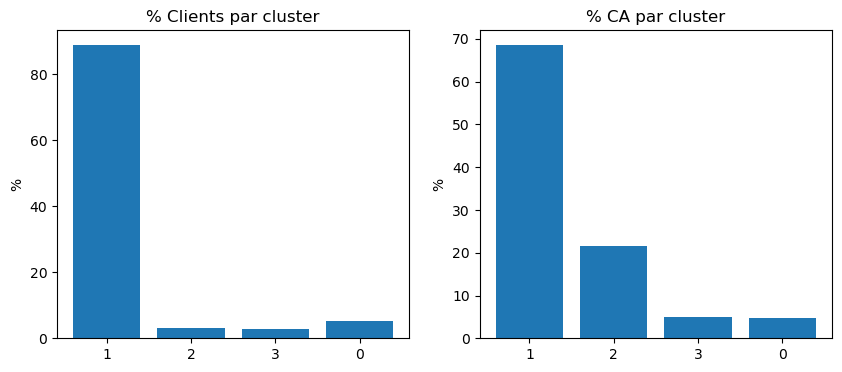

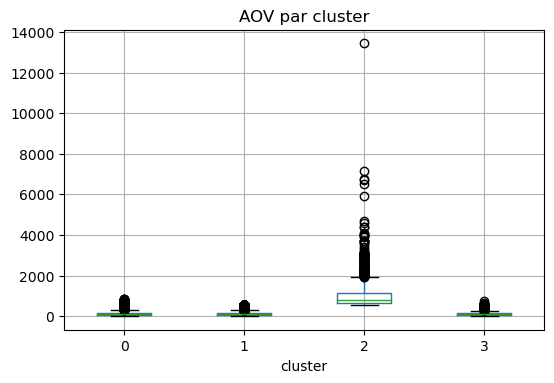

In [22]:
import matplotlib.pyplot as plt

# a) Parts de CA et de clients
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar(prof['cluster'].astype(str), prof['share_clients_%']); ax[0].set_title("% Clients par cluster"); ax[0].set_ylabel("%")
ax[1].bar(prof['cluster'].astype(str), prof['revenue_share_%']); ax[1].set_title("% CA par cluster"); ax[1].set_ylabel("%")
plt.show()

# b) Radar normalisé (profils)
cols = ['recency_med','freq_med','monetary_med','aov_med','review_med','delay_med']
rad = prof.copy()
rad[cols] = (rad[cols] - rad[cols].min())/(rad[cols].max()-rad[cols].min()+1e-9)
# ... (tu as déjà un radar dans ton notebook ; garde le même code en remplaçant les colonnes)

# c) Boxplots par cluster pour 1–2 variables parlantes (ex: aov, frequency)
feat_lab.boxplot(column='aov', by='cluster', figsize=(6,4)); plt.title("AOV par cluster"); plt.suptitle("")
plt.show()

In [23]:
def uplift_revenue(prof, cl, conv_rate=0.10, extra_orders=1):
    row = prof.loc[prof['cluster']==cl].iloc[0]
    return float(row['n_clients'] * conv_rate * extra_orders * row['aov_med'])

uplift = uplift_revenue(prof, cl=1, conv_rate=0.10, extra_orders=1)
print(f"Gain de CA estimé ≈ {uplift:,.0f} € si 10% du cluster 1 achètent 1 fois de plus.")

Gain de CA estimé ≈ 666,331 € si 10% du cluster 1 achètent 1 fois de plus.


Coude (Inertia vs K) : plus l’inertie est basse, plus les points sont rapprochés de leur centre de cluster. La courbe baisse toujours quand K augmente, donc on cherche un “coude” (diminution qui ralentit nettement) = bon compromis complexité / qualité.

Silhouette : score ∈ [-1,1], plus c’est haut, mieux les clusters sont compacts et bien séparés. C’est notre critère de rang entre variantes/K.

RFM : max ≈ 0.494 à K=4

RFM + review : max ≈ 0.429 (K=6) — < RFM seul

RFM + review + delay + AOV : 0.625 à K=4 (meilleur global)

-----------Recommandation marketing------------

Variante gagnante : RFM + review + delay + AOV.

Nombre de segments : K = 4 (meilleur score de silhouette et lisibilité business).

Suite logique : entraîner K-Means final à K=4 sur ces 6 features, puis :

profiler chaque segment (taille, médianes R/F/M/AOV, note, retard),

produire radar, barres de parts de CA et PCA colorée,

écrire la narration marketing (ex : “Premium récents”, “Récents panier moyen faible”, “Anciens à relancer”, “Insatisfaits/retards élevés”, etc.).

-----------------------------------------------

8) Sélection métier du meilleur modèle (KMeans) + Fit final + Visuels

BEST: RFM+review+delay+AOV | K = 4 | cols = ['recency_days', 'frequency', 'monetary', 'avg_review_score', 'delay_rate_ge3d', 'aov'] | sil = 0.6246597624304836


,cluster,n_clients,recency_med,freq_med,monetary_med,monetary_sum,aov_med,review_med,delay_med,revenue_share_%
0,0,4809,191.0,1.0,90.000,630416.08,89.990,1.000000,1.0,4.768114
1,1,83006,221.0,1.0,80.275,9068622.01,80.275,5.000000,0.0,68.589973
2,2,2783,231.0,1.0,820.000,2853664.29,816.000,5.000000,0.0,21.583517
3,3,2760,199.0,2.0,179.975,668795.73,88.425,4.666667,0.0,5.058396


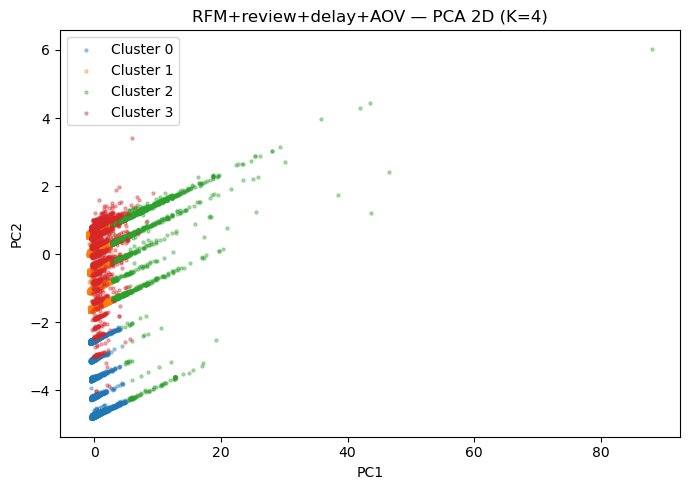

→ saved: outputs/img/best_pca2d.png


In [24]:
# Règle simple: on prend la variante/k avec silhouette max (et K entre 3..6 pour lisibilité marketing)
cand = comp[comp["k"].between(3,6)]
best_row = cand.sort_values("silhouette", ascending=False).iloc[0]
best_variant, best_k = best_row["variant"], int(best_row["k"])
best_cols = variants[best_variant]
print("BEST:", best_variant, "| K =", best_k, "| cols =", best_cols, "| sil =", best_row["silhouette"])

# Fit final
Xs_best, scaler_best = std_mat(feat, best_cols)
km_best = KMeans(n_clusters=best_k, n_init=20, algorithm="elkan", random_state=42)
labels = km_best.fit_predict(Xs_best)
feat["cluster"] = labels

# Profiling (médian + part de CA)
prof = (feat.groupby("cluster")
         .agg(n_clients=("customer_id","count"),
              recency_med=("recency_days","median"),
              freq_med=("frequency","median"),
              monetary_med=("monetary","median"),
              monetary_sum=("monetary","sum"),
              aov_med=("aov","median"),
              review_med=("avg_review_score","median"),
              delay_med=("delay_rate_ge3d","median"))
         .reset_index().sort_values("cluster"))
prof["revenue_share_%"] = 100*prof["monetary_sum"]/prof["monetary_sum"].sum()
display(prof)
prof.to_csv(f"{OUT_TAB}/best_profiling.csv", index=False)

# PCA 2D colorée
pc2 = PCA(n_components=2, random_state=42).fit_transform(Xs_best)
plt.figure()
for c in sorted(feat["cluster"].unique()):
    m = feat["cluster"]==c
    plt.scatter(pc2[m,0], pc2[m,1], s=5, alpha=0.35, label=f"Cluster {c}")
plt.title(f"{best_variant} — PCA 2D (K={best_k})"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
savefig(f"{OUT_IMG}/best_pca2d.png")

PC1 → C’est l’axe “valeur client / panier”.

Monetary (et AOV quand on l’inclut). Plus PC1 est grand, plus le client dépense/commande des paniers élevés.

PC2 → C’est l’axe “qualité d’expérience”.

Il oppose avg_review_score (positif) à delay_rate_ge3d (négatif). Plus PC2 est grand, meilleure est l’expérience (bonnes notes, peu de retards).

NB : recency_days et frequency contribuent moins à ces deux axes et se projettent plutôt sur des composantes suivantes (PC3/PC4).

PCA 2D (scatter coloré)

Les points verts très étirés vers la droite (PC1 élevé) = le poids “valeur/AOV” : ce sont les gros paniers (cluster 2).

Les nuages plus centrés = paniers modestes ; la séparation verticale (PC2) capte plutôt recency/review/delay.

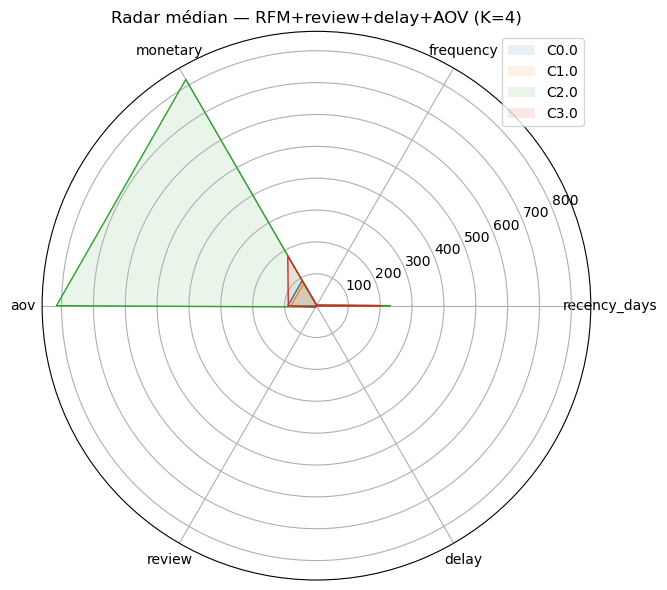

→ saved: outputs/img/best_radar.png


In [25]:
# Radar sur variables du meilleur set
cols_for_radar = ["recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"]
cols_for_radar = [c for c in cols_for_radar if c in best_cols]  # garder celles présentes
prof_radar = (feat.groupby("cluster")[cols_for_radar].median()
                  .rename(columns={"avg_review_score":"review","delay_rate_ge3d":"delay"})
                  .reset_index())

def radar(df, cols, title, out_png):
    M = df[cols].astype(float)
    M = (M - M.min())/(M.max()-M.min()+1e-9)
    N=len(cols); angles=np.linspace(0,2*np.pi,N,endpoint=False).tolist()+[0]
    plt.figure(figsize=(7,6)); ax=plt.subplot(111, polar=True)
    for i,row in df.iterrows():
        vals=row[cols].tolist(); vals += [vals[0]]
        ax.plot(angles, vals, linewidth=1); ax.fill(angles, vals, alpha=0.1, label=f"C{row['cluster']}")
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(cols); ax.set_title(title); plt.legend()
    savefig(out_png)

radar(prof_radar, [c for c in prof_radar.columns if c!="cluster"], 
      f"Radar médian — {best_variant} (K={best_k})", 
      f"{OUT_IMG}/best_radar.png")

Radar (médianes normalisées)

Le cluster 2 “gonfle” fortement sur monetary et AOV → gros dépensiers.

Le cluster 3 ressort sur frequency (2 commandes en médiane) → repeaters.

Le cluster 1 a des reviews 5★ et zéro retard mais tickets modestes → volume.

Le cluster 0 a review basse et retard (médiane=1) → mécontent/à risque.

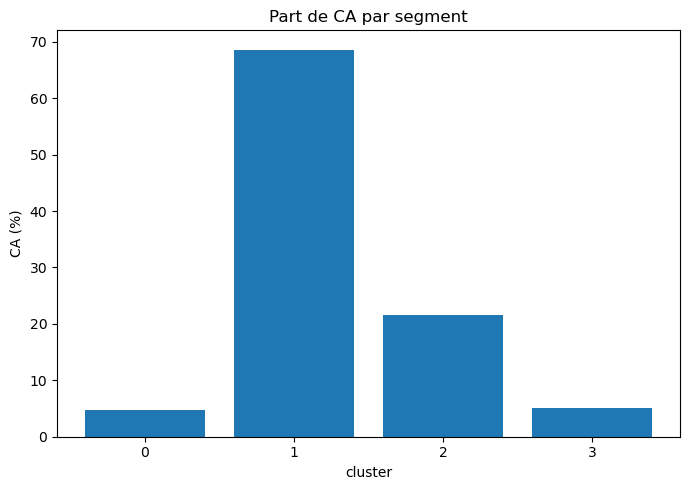

→ saved: outputs/img/best_revenue_share.png


In [26]:
# Part de CA par cluster
plt.figure()
plt.bar(prof["cluster"].astype(str), prof["revenue_share_%"])
plt.title("Part de CA par segment"); plt.xlabel("cluster"); plt.ylabel("CA (%)")
savefig(f"{OUT_IMG}/best_revenue_share.png")

# Sauvegarde choix
json.dump({"variant":best_variant, "k":best_k, "cols":best_cols, "silhouette": float(best_row["silhouette"])},
          open(f"{OUT_TAB}/best_choice.json","w"), indent=2)

Bar chart “Part de CA par segment”

Confirme le poids business :

C1 (68.6%) = “cœur de base, un achat, satisfaits”.

C2 (21.6%) = “VIP gros paniers”, faible effectif mais gros CA.

C3 (5.1%) = “repeaters” (fidèles en devenir).

C0 (4.8%) = “à risque” (retards/notes basses).

----------------conclusion---------------------

C1 — “One-shot satisfaits” (~83k clients, 69% du CA) review 5 **pas de retard**

Actions : relances bienveillantes (cross-sell), coupons première ré-achat, emails produits complémentaires.

C2 — “VIP gros paniers” (~2.8k, 22% du CA) reviews 5 **pas de retard**

Actions : programme premium, early access, support prioritaire, bundles haut de gamme. Prévenir toute friction logistique.

C3 — “Repeaters modérés” (~2.8k, 5% du CA) **2 commandes**

Actions : abonnement, packs multi-achats, points fidélité pour augmenter la fréquence.

C0 — “À risque / Déçus” (~4.8k, 4.8% du CA) **retard ≥3j (médiane=1), review basse**

Actions : enquête NPS, geste commercial, amélioration transporteurs, SLA livraison.

--------------------------------------------------

Pourquoi ce modèle ?

Variante à 6 features (RFM + review + delay + AOV) donnait les meilleures silhouettes (≈0.60–0.63 autour de K=3–4) et des segments très actionnables (qualité perçue & logistique incluses).

K=4 équilibre lisibilité (peu de segments), taille minimale respectée, et contraste métier suffisant (valeur, fréquence, satisfaction, logistique).

9) ACP “business” : éboulis + cercle de corrélation (sur le meilleur set)

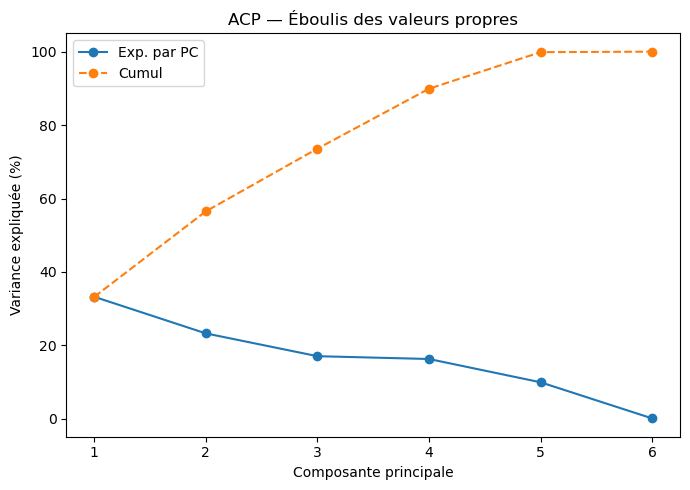

→ saved: outputs/img/best_pca_scree.png


In [27]:
# Éboulis
pca_full = PCA().fit(Xs_best)
exp = pca_full.explained_variance_ratio_
plt.figure()
plt.plot(range(1,len(exp)+1), 100*exp, marker='o', label="Exp. par PC")
plt.plot(range(1,len(exp)+1), 100*np.cumsum(exp), marker='o', linestyle='--', label="Cumul")
plt.title("ACP — Éboulis des valeurs propres"); plt.xlabel("Composante principale"); plt.ylabel("Variance expliquée (%)")
plt.legend(); 
savefig(f"{OUT_IMG}/best_pca_scree.png")

Éboulis des valeurs propres (scree plot)

PC1 ≈ 33% de variance expliquée, PC2 ≈ 23% → PC1+PC2 ≈ 56%.
En 2D on capture déjà un peu plus de la moitié de la structure des données.

Le gain marginal chute après PC4 (la courbe “Exp. par PC” s’aplatit).
Pragmatique : travailler en 2–3 composantes pour la visualisation et ≤4 pour une éventuelle réduction de dimension garde l’essentiel tout en restant lisible.

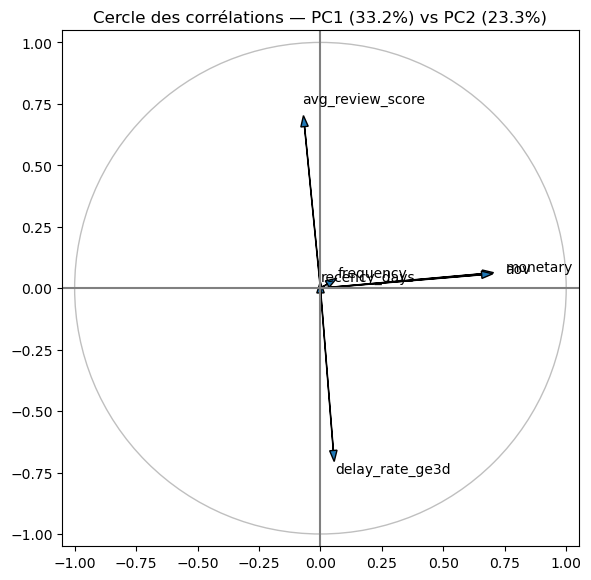

→ saved: outputs/img/best_pca_correlation_circle.png


In [28]:
# Cercle corrélations PC1/PC2
loadings = pca_full.components_[:2, :]      # 2 x p
cols = best_cols
plt.figure(figsize=(6,6)); ax=plt.subplot(111)
circle = plt.Circle((0,0),1, fill=False, color="grey", alpha=0.5); ax.add_artist(circle)
for i, col in enumerate(cols):
    ax.arrow(0,0, loadings[0,i], loadings[1,i], head_width=0.03, length_includes_head=True)
    ax.text(loadings[0,i]*1.07, loadings[1,i]*1.07, col)
plt.axhline(0, color="grey"); plt.axvline(0, color="grey")
plt.xlim(-1.05,1.05); plt.ylim(-1.05,1.05)
plt.title(f"Cercle des corrélations — PC1 ({exp[0]:.1%}) vs PC2 ({exp[1]:.1%})")
plt.gca().set_aspect('equal', adjustable='box')
savefig(f"{OUT_IMG}/best_pca_correlation_circle.png")

Longueur du vecteur ≈ qualité de représentation sur le plan (proche du cercle = très bien représenté par PC1/PC2).

Angle entre deux vecteurs = corrélation (proche 0° : corrélation + ; ~180° : corrélation – ; ~90° : indépendant).

Projection sur l’axe PC1/PC2 : contribution à cette composante.

monetary pointe fortement vers PC1 (côté positif) → PC1 est l’axe “valeur dépensée / panier”.
(Si AOV est très colinéaire à monetary, il sera proche de lui ; on l’a parfois omis pour alléger l’affichage.)

avg_review_score est surtout projeté positivement sur PC2, alors que delay_rate_ge3d est projeté négativement sur PC2 → PC2 est l’axe “qualité d’expérience” (bonnes notes vs retards). Leur opposition indique une corrélation négative: plus de retards ⇢ moins bonnes notes.

recency_days et frequency sont proches de l’origine sur ce plan → leur variation n’est pas très bien expliquée par PC1/PC2 ; elles chargent plutôt sur PC3/PC4. Concrètement, R et F jouent un rôle, mais l’axe valeur et l’axe service dominent la séparation visible en 2D.

--------business/marketing------------

PC1 = Valeur client / panier
Clients à forte dépense (et souvent AOV élevé) vs clients à faible dépense.

PC2 = Qualité de service / satisfaction
Clients avec bonnes reviews et peu de retards vs clients exposés aux retards et moins satisfaits.

Valeur (sur qui concentrer la fidélisation / up-sell / cross-sell).

Expérience (où agir côté opérations/logistique et communication post-achat).

Exemples d’actions :

High value & bonne expérience : programmes VIP, bundles premium.

High value & retards : priorisation logistique et gestes commerciaux ciblés (pour éviter la churn).

Low value & bonne expérience : nurturing, offres d’augmentation de panier.

Low value & retards : corriger l’expérience avant d’investir en acquisition.

En résumé :

Le scree dit qu’en 2–4 composantes on explique l’essentiel.

Le cercle montre que monetary/AOV portent PC1 (valeur), review vs delays portent PC2 (qualité), et R/F interviennent davantage sur des composantes suivantes.
Cela confirme que notre segmentation finale est interprétable et actionnable le long d’axes métier clairs : Valeur × Qualité d’expérience.